In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# load docunet dataset & pairing 

Image: 1-d2a1c88c.png <--> Label: 1-d2a1c88c.npz


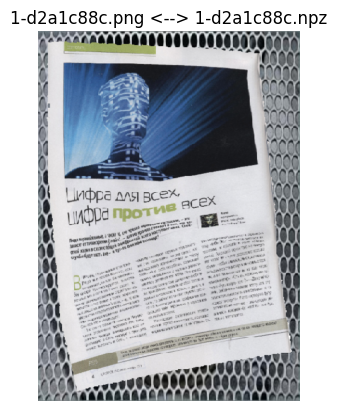

Label npz keys: ['x', 'y']
--------------------------------------------------
Image: 10-0798ae97.png <--> Label: 10-0798ae97.npz


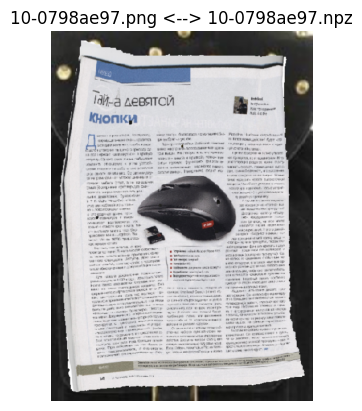

Label npz keys: ['x', 'y']
--------------------------------------------------
Image: 102-0016eccf.png <--> Label: 102-0016eccf.npz


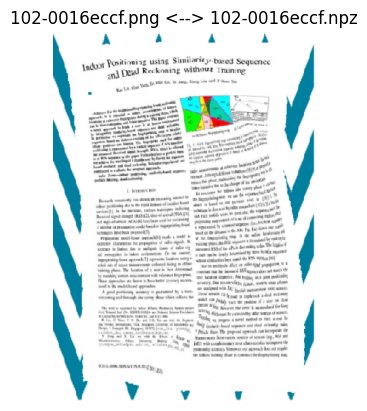

Label npz keys: ['x', 'y']
--------------------------------------------------
Image: 102-00355406.png <--> Label: 102-00355406.npz


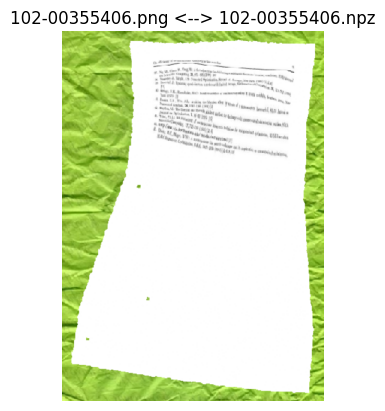

Label npz keys: ['x', 'y']
--------------------------------------------------
Image: 102-00972558.png <--> Label: 102-00972558.npz


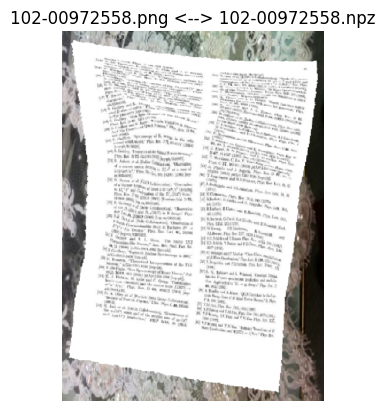

Label npz keys: ['x', 'y']
--------------------------------------------------


In [2]:
# Set your dataset paths
dataset_dir = "/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset"
image_dir = os.path.join(dataset_dir, "image")
label_dir = os.path.join(dataset_dir, "label")

# List all image and label files
image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith('.png')])
label_files = sorted([f for f in os.listdir(label_dir) if f.lower().endswith('.npz')])

# Create a dict for quick label lookup
label_dict = {os.path.splitext(f)[0]: f for f in label_files}

# Pair images and labels by base filename
pairs = []
for img_file in image_files:
    base_name = os.path.splitext(img_file)[0]
    if base_name in label_dict:
        pairs.append((img_file, label_dict[base_name]))

# Show the first 5 pairs
for img_file, label_file in pairs[:5]:
    img_path = os.path.join(image_dir, img_file)
    label_path = os.path.join(label_dir, label_file)
    print(f"Image: {img_file} <--> Label: {label_file}")
    # Display image
    img = Image.open(img_path)
    plt.imshow(img)
    plt.title(f"{img_file} <--> {label_file}")
    plt.axis('off')
    plt.show()
    # Display label content (list keys in npz)
    with np.load(label_path) as data:
        print("Label npz keys:", list(data.keys()))
    print("-" * 50)

## cek isi npz

In [4]:
import numpy as np

with np.load('/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/label/11-3b034203.npz') as data:
    print(data.files)  # List of keys
    for key in data.files:
        print(key, data[key].shape)

['x', 'y']
x (707, 500)
y (707, 500)


# preprocess docunet

In [5]:
import cv2
from tqdm import tqdm

def preprocess_image(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    img = cv2.resize(img, (512, 512), interpolation=cv2.INTER_AREA)
    img = img.astype(np.float32) / 255.0
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img = clahe.apply(np.uint8(img * 255)) / 255.0
    img = cv2.GaussianBlur(img, (5, 5), 0)
    img = cv2.Canny(np.uint8(img * 255), 50, 150) / 255.0
    img = cv2.adaptiveThreshold(
        np.uint8(img * 255), 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY, 11, 2
    )
    return img

# Directories
image_src_dir = "/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/image"
label_src_dir = "/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/label"

image_dst_dir = "/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/images"
label_dst_dir = "/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/labels"

os.makedirs(image_dst_dir, exist_ok=True)
os.makedirs(label_dst_dir, exist_ok=True)

# Process all images
image_files = [f for f in os.listdir(image_src_dir) if f.lower().endswith('.png')]
label_files = {os.path.splitext(f)[0]: f for f in os.listdir(label_src_dir) if f.lower().endswith('.npz')}

for fname in tqdm(image_files, desc="Preprocessing images and labels"):
    base_name = os.path.splitext(fname)[0]
    img_src_path = os.path.join(image_src_dir, fname)
    img_dst_path = os.path.join(image_dst_dir, fname)

    # Preprocess and save image
    try:
        processed_img = preprocess_image(img_src_path)
        cv2.imwrite(img_dst_path, processed_img)
    except Exception as e:
        print(f"❌ Failed to process image {fname}: {e}")
        continue

    # Process and save corresponding label if it exists
    if base_name in label_files:
        label_src_path = os.path.join(label_src_dir, label_files[base_name])
        label_dst_path = os.path.join(label_dst_dir, base_name + ".npz")
        try:
            with np.load(label_src_path) as label_data:
                label_x = label_data['x']
                label_y = label_data['y']
                resized_x = cv2.resize(label_x, (512, 512), interpolation=cv2.INTER_NEAREST)
                resized_y = cv2.resize(label_y, (512, 512), interpolation=cv2.INTER_NEAREST)
                np.savez_compressed(label_dst_path, x=resized_x, y=resized_y)
        except Exception as e:
            print(f"❌ Failed to process label {label_files[base_name]}: {e}")
    else:
        print(f"⚠️ No label found for image: {fname}")

print("✅ Preprocessing complete. Images and labels saved to:")
print(f"   Images → {image_dst_dir}")
print(f"   Labels → {label_dst_dir}")


Preprocessing images and labels: 100%|██████████| 15072/15072 [09:22<00:00, 26.81it/s]

✅ Preprocessing complete. Images and labels saved to:
   Images → /Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/images
   Labels → /Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/labels


# show the pair of preprocessed images & labels

✅ Total matched pairs: 15072
⚠️ Unmatched images (no label found): 0


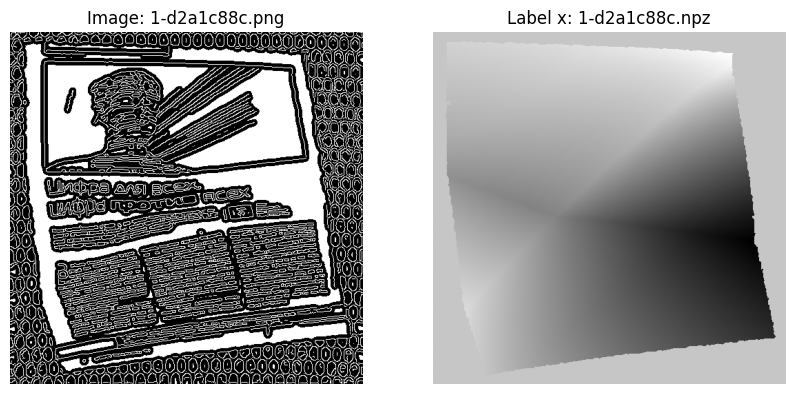

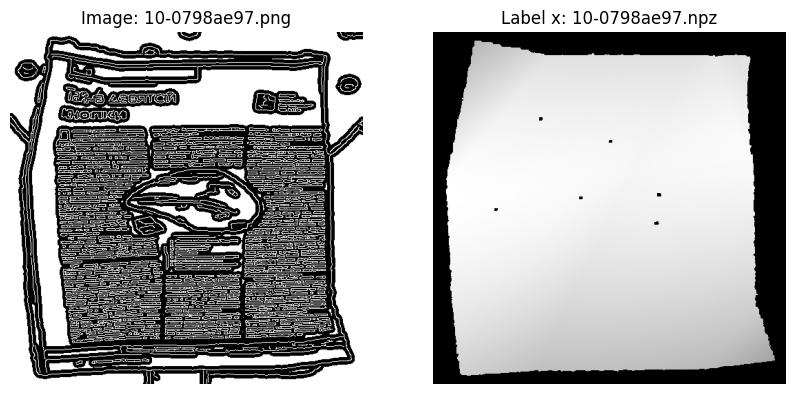

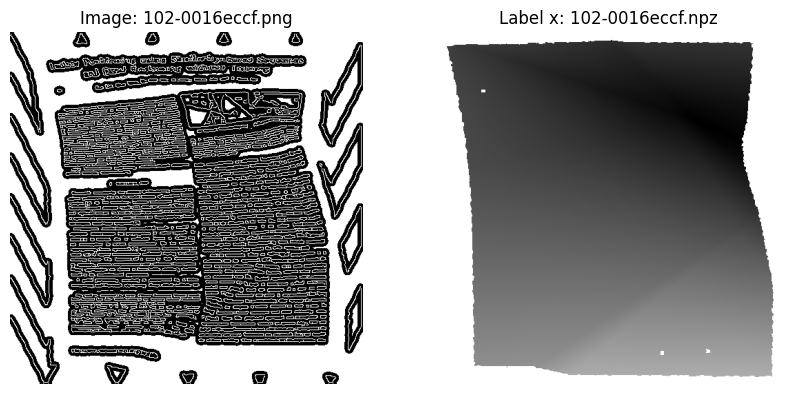

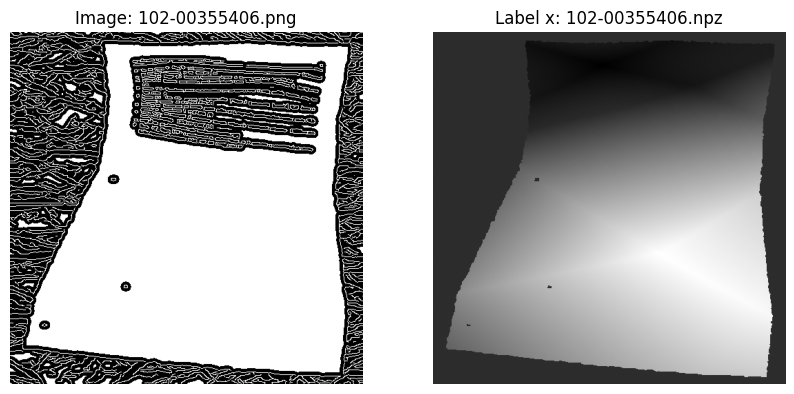

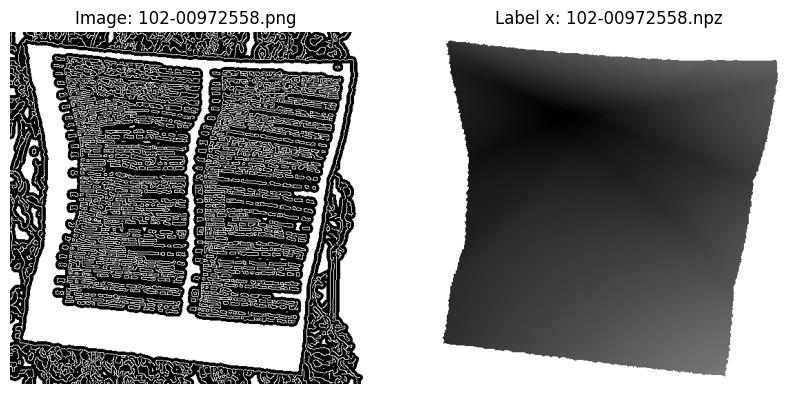

In [6]:
# Paths
preprocessed_image_dir = '/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/images'
preprocessed_label_dir = '/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/labels'

# List image and label files
image_files = sorted([f for f in os.listdir(preprocessed_image_dir) if f.endswith('.png')])
label_files = sorted([f for f in os.listdir(preprocessed_label_dir) if f.endswith('.npz')])

# Map label base filenames
label_dict = {os.path.splitext(f)[0]: f for f in label_files}

# Match image and label pairs
image_label_pairs = []
unmatched_images = []

for img_file in image_files:
    base_name = os.path.splitext(img_file)[0]
    if base_name in label_dict:
        image_label_pairs.append((img_file, label_dict[base_name]))
    else:
        unmatched_images.append(img_file)

print(f"✅ Total matched pairs: {len(image_label_pairs)}")
print(f"⚠️ Unmatched images (no label found): {len(unmatched_images)}")

# Display first 5 pairs
for idx, (image_file, label_file) in enumerate(image_label_pairs[:5]):
    # Load preprocessed image
    image_path = os.path.join(preprocessed_image_dir, image_file)
    image = Image.open(image_path)

    # Load corresponding label
    label_path = os.path.join(preprocessed_label_dir, label_file)
    label_data = np.load(label_path)

    label_x = label_data.get('x')
    label_y = label_data.get('y')

    if label_x is None or label_y is None:
        print(f"❌ Missing 'x' or 'y' in label: {label_file}")
        continue

    # Display image and label_x
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title(f'Image: {image_file}')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(label_x, cmap='gray')
    plt.title(f'Label x: {label_file}')
    plt.axis('off')

    plt.show()

# split docunet

In [7]:
import os
import random
import shutil
import numpy as np

# Define paths to the preprocessed images and labels
preprocessed_image_dir = '/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/images'
preprocessed_label_dir = '/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/labels'

# Custom paths for the training, testing, and validation preprocessed images
train_image_dir = '/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/train'
test_image_dir = '/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/test'
val_image_dir = '/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/DocUNet_dataset/preprocessed/val'

# List all the image files and label files
image_files = sorted([f for f in os.listdir(preprocessed_image_dir) if f.endswith('.png')]) 
label_files = sorted([f for f in os.listdir(preprocessed_label_dir) if f.endswith('.npz')]) 

# Ensure there is a one-to-one correspondence between images and labels
image_label_pairs = list(zip(image_files, label_files))

# Shuffle the pairs to randomize the split
random.seed(42)  # For reproducibility
random.shuffle(image_label_pairs)

# Calculate the number of samples in each split
n_total = len(image_label_pairs)
n_train = int(0.7 * n_total)
n_test = int(0.15 * n_total)
n_val = n_total - n_train - n_test  # Ensures all data is used

# Split the data into training, testing, and validation sets
train_pairs = image_label_pairs[:n_train]
test_pairs = image_label_pairs[n_train:n_train + n_test]
val_pairs = image_label_pairs[n_train + n_test:]

# Print the split sizes
print(f"Total: {n_total}, Train: {len(train_pairs)}, Test: {len(test_pairs)}, Val: {len(val_pairs)}")

# Create directories for training, testing, and validation sets
output_dirs = [train_image_dir, test_image_dir, val_image_dir]
for output_dir in output_dirs:
    # Create directories for images and labels
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'labels'), exist_ok=True)

# Function to copy images and labels to the respective directories
def copy_samples(pairs, split, base_image_dir):
    for img_file, label_file in pairs:
        # Define paths for the preprocessed image and label
        img_path = os.path.join(base_image_dir, img_file)
        label_path = os.path.join(preprocessed_label_dir, label_file)

        # Define the destination paths
        img_dest_path = os.path.join(split, 'images', img_file)
        label_dest_path = os.path.join(split, 'labels', label_file)

        # Copy the files to the respective directories
        shutil.copy(img_path, img_dest_path)
        shutil.copy(label_path, label_dest_path)

# Copy the train, test, and validation samples
copy_samples(train_pairs, train_image_dir, preprocessed_image_dir)
copy_samples(test_pairs, test_image_dir, preprocessed_image_dir)
copy_samples(val_pairs, val_image_dir, preprocessed_image_dir)

print("Samples have been copied to respective directories.")

Total: 15072, Train: 10550, Test: 2260, Val: 2262
Samples have been copied to respective directories.


# distort manual SROIE for testing

In [7]:
import os 
from tqdm import tqdm
import cv2
import numpy as np

sroie_dir = "/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/SROIE2019"
distorted_dir = os.path.join(sroie_dir, "distorted")

# Create distorted folder
os.makedirs(distorted_dir, exist_ok=True)

# Apply perspective distortion
def apply_perspective_distortion(img):
    h, w = img.shape
    src = np.float32([[0, 0], [w-1, 0], [w-1, h-1], [0, h-1]])
    delta = 80
    dst = src + np.random.uniform(-delta, delta, src.shape).astype(np.float32)
    matrix = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, matrix, (w, h))

# Process each image: distort and save it in the "distorted" folder
for filename in tqdm(os.listdir(sroie_dir)):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
        img_path = os.path.join(sroie_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        distorted = apply_perspective_distortion(img)

        cv2.imwrite(os.path.join(distorted_dir, filename), distorted)

100%|██████████| 975/975 [00:21<00:00, 46.04it/s]


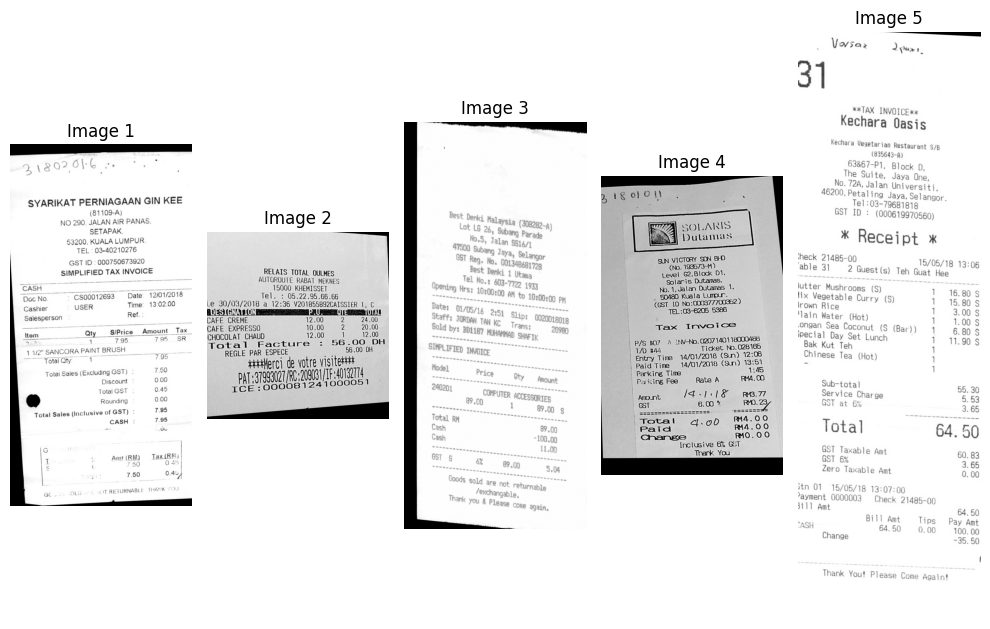

In [12]:
import random
import matplotlib.pyplot as plt

distorted_dir = "/Users/ileene/Library/CloudStorage/OneDrive-UniversitasCiputra/smt 8/TA/code/docunet-sroie-merged/SROIE2019/distorted"

# List all the images in the distorted folder
image_files = [f for f in os.listdir(distorted_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Randomly select 5 images
random_images = random.sample(image_files, 5)

# Plot and display the 5 random images
plt.figure(figsize=(10, 10))
for i, img_filename in enumerate(random_images, 1):
    img_path = os.path.join(distorted_dir, img_filename)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    plt.subplot(1, 5, i)
    plt.imshow(img, cmap='gray')
    plt.title(f"Image {i}")
    plt.axis('off')

plt.tight_layout()
plt.show()